In [1]:
%load_ext autoreload
%autoreload 2

import pickle
from itertools import product
from os import system
import numpy as np
import matplotlib.pyplot as plt
from corner import corner
from tqdm.auto import tqdm, trange
import dynesty
from dynesty import plotting as dyplot
from dynesty import utils as dyfunc
from scipy.optimize import minimize_scalar

import jax
import jax.numpy as jnp
from jax import random

from pydd.binary import *
from pydd.analysis import *
from pydd.noise import *

## Scratch: $\rho_6$ checks

In [98]:
def get_rho_s_6(rho_6, m_1, gamma_s):
    r_6 = 1e-6*PC
    m_tilde = ((3-gamma_s)*(0.2)**(3-gamma_s))*m_1/(2*jnp.pi)
    return (rho_6*r_6**gamma_s/(m_tilde**(gamma_s/3)))**(1/(1-gamma_s/3))

In [105]:
m_1 = 1e3*MSUN
t_eq = 2.4e12  # s
rho_eq = 2.1e-19 * 1e-3 / 1e-2**3  # g / cm^3 -> kg / m^3

gamma_s_pbh = 9/4
rho_6_pbh = (rho_eq / 2) * t_eq**(3/2) * (2 * G * m_1)**(3/4) / (
    1e-6 * PC
)**gamma_s_pbh
rho_s_pbh = get_rho_s_6(rho_6_pbh, m_1, gamma_s_pbh)
r_s_pbh = get_r_s(m_1, rho_s_pbh, gamma_s_pbh)

gamma_s_eda = 7/3
rho_6_eda = 5448453120042983.0 * MSUN/PC**3
rho_s_eda = get_rho_s_6(rho_6_eda, m_1, gamma_s_eda)
r_s_eda = get_r_s(m_1, rho_s_eda, gamma_s_eda)
assert jnp.allclose(rho_s_eda / (MSUN/PC**3), 226.)

In [115]:
rho_s_pbh / (MSUN/PC**3)

17940.820572580975

Text(0, 0.5, '$\\rho$ [M$_\\odot$/pc$^3$]')

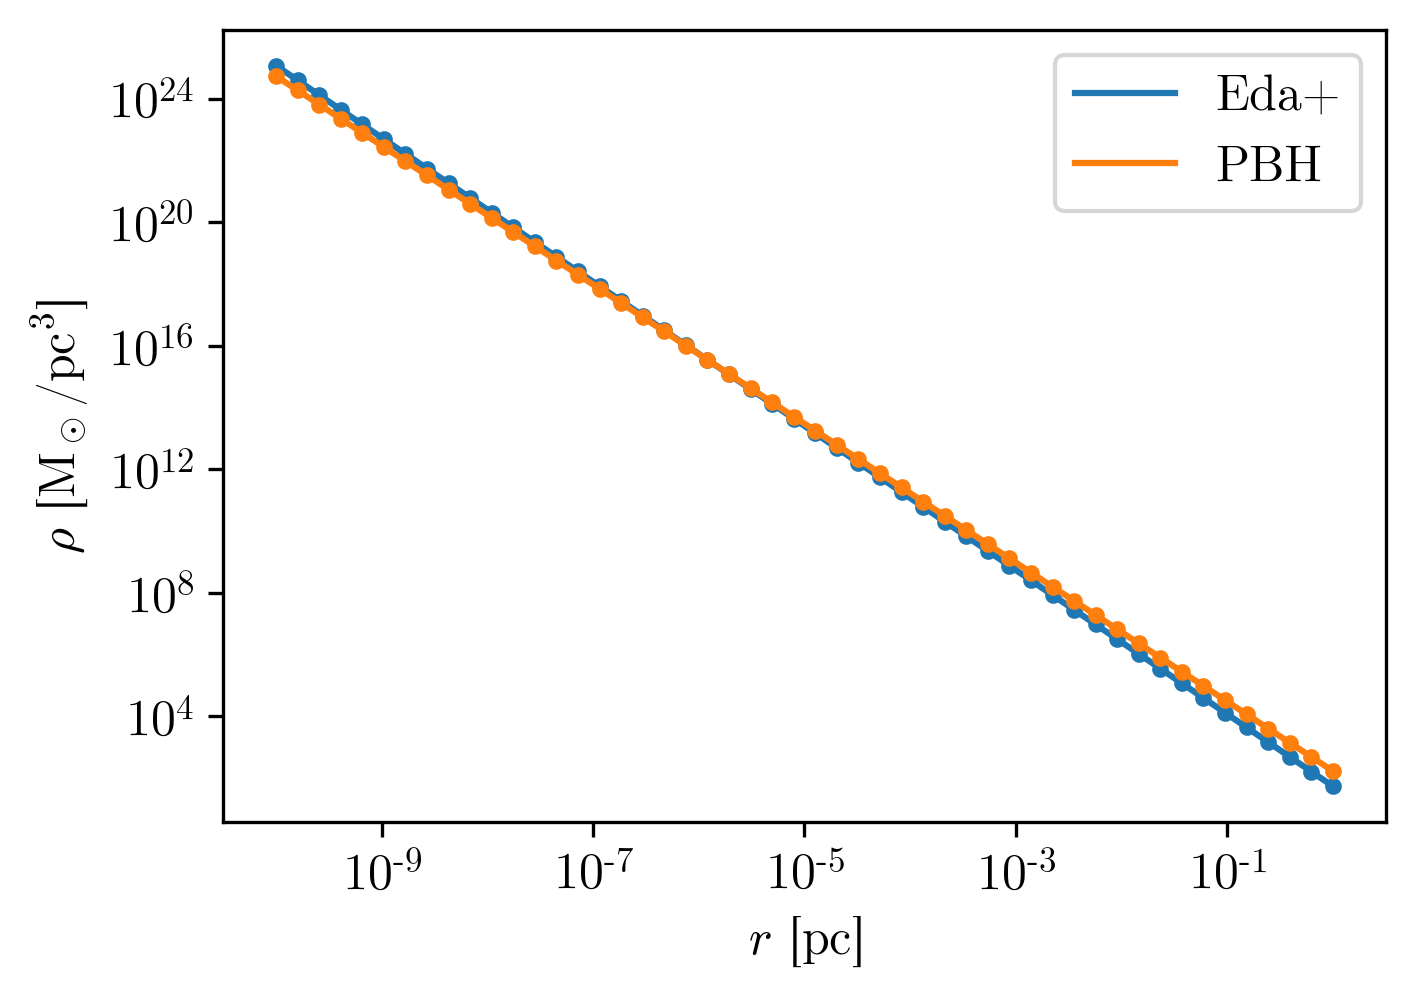

In [113]:
rs = jnp.logspace(-10, 0) * PC
plt.loglog(
    rs / PC,
    rho_s_eda
    * (rs / r_s_eda) ** (-gamma_s_eda)
    / (MSUN / PC ** 3),
    label="Eda+",
    c="C0",
)
plt.loglog(
    rs / PC,
    rho_6_eda * (rs / (1e-6 * PC)) ** (-gamma_s_eda) / (MSUN / PC ** 3),
    ".",
    c="C0",
)

plt.loglog(
    rs / PC,
    rho_s_pbh * (rs / r_s_pbh) ** (-gamma_s_pbh) / (MSUN / PC ** 3),
    label="PBH",
    c="C1",
)
plt.loglog(
    rs / PC,
    rho_6_pbh * (rs / (1e-6 * PC)) ** (-gamma_s_pbh) / (MSUN / PC ** 3),
    ".",
    c="C1",
)

plt.legend()
plt.xlabel(r"$r$ [pc]")
plt.ylabel(r"$\rho$ [M$_\odot$/pc$^3$]")

## Scratch: $\rho_8$ checks

In [378]:
# rho_8_max = minimize_scalar(
#     lambda rho: (get_rho_s(rho, 1000.0*MSUN, 7.0/3.0) - 1000.0*MSUN/PC**3) ** 2, bracket=(1e-6, 10)
# ).x
# print(rho_8_max/(MSUN/PC**3))

# rho_8_max = minimize_scalar(
#     lambda rho: (get_rho_s(rho, 10000.0*MSUN, 7.0/3.0) - 1000.0*MSUN/PC**3) ** 2, bracket=(1e-6, 10)
# ).x
# print(rho_8_max/(MSUN/PC**3))

# rho_8_max = minimize_scalar(
#     lambda rho: (get_rho_s(rho, 100000.0*MSUN, 7.0/3.0) - 1000.0*MSUN/PC**3) ** 2, bracket=(1e-6, 10)
# ).x
# print(rho_8_max/(MSUN/PC**3))

rho_8s_1 = []
for gamma_s in np.linspace(2.25, 2.5, 10):
    rho_8s_1.append(minimize_scalar(
        lambda rho: (get_rho_s(rho, 1e3*MSUN, gamma_s) - 1000.0*MSUN/PC**3) ** 2, bracket=(1e-6, 10)
    ).x / (MSUN/PC**3))

rho_8s_2 = []
for gamma_s in np.linspace(2.25, 2.5, 10):
    rho_8s_2.append(minimize_scalar(
        lambda rho: (get_rho_s(rho, 1e4*MSUN, gamma_s) - 1000.0*MSUN/PC**3) ** 2, bracket=(1e-6, 100)
    ).x / (MSUN/PC**3))

rho_8s_3 = []
for gamma_s in np.linspace(2.25, 2.5, 10):
    rho_8s_3.append(minimize_scalar(
        lambda rho: (get_rho_s(rho, 1e5*MSUN, gamma_s) - 1000.0*MSUN/PC**3) ** 2, bracket=(1e-6, 100)
    ).x / (MSUN/PC**3))

rho_8s_4 = []
for gamma_s in np.linspace(2.25, 2.5, 10):
    rho_8s_4.append(minimize_scalar(
        lambda rho: (get_rho_s(rho, 1e6*MSUN, gamma_s) - 1000.0*MSUN/PC**3) ** 2, bracket=(1e-3, 1000)
    ).x / (MSUN/PC**3))

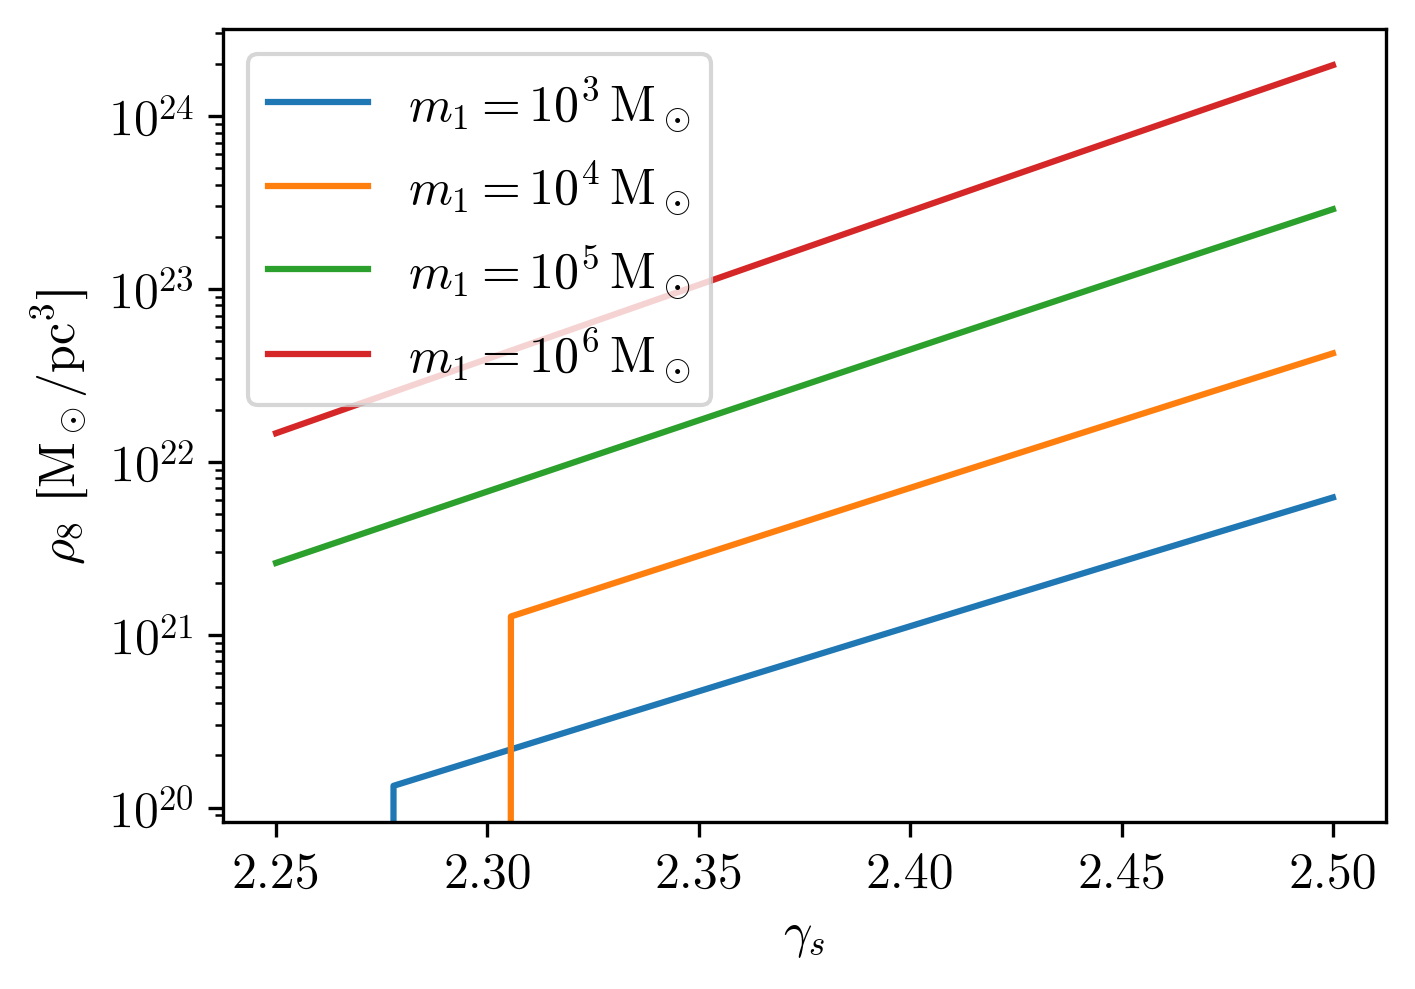

In [382]:
gamma_ss = np.linspace(2.25, 2.5, 10)
plt.plot(gamma_ss, rho_8s_1, label=r"$m_1 = 10^3\, \mathrm{M}_\odot$")
plt.plot(gamma_ss, rho_8s_2, label=r"$m_1 = 10^4\, \mathrm{M}_\odot$")
plt.plot(gamma_ss, rho_8s_3, label=r"$m_1 = 10^5\, \mathrm{M}_\odot$")
plt.plot(gamma_ss, rho_8s_4, label=r"$m_1 = 10^6\, \mathrm{M}_\odot$")
plt.xlabel(r"$\gamma_s$")
plt.ylabel(r"$\rho_8$ [$\mathrm{M}_\odot / \mathrm{pc}^3$]")
plt.legend()
plt.yscale("log")

## Systems

In [2]:
# # Discoverable system
# m_1 = jnp.array(1e3 * MSUN)
# m_2 = jnp.array(1 * MSUN)
# rho_s = jnp.array(1e-7 * MSUN / PC ** 3)
# gamma_s = jnp.array(7/3)
# dd_s = make_dynamic_dress(m_1, m_2, rho_s, gamma_s)
# dd_v = VacuumBinary(dd_s.M_chirp, dd_s.Phi_c, dd_s.tT_c, dd_s.dL_iota, dd_s.f_c)

# t_obs_lisa = 5 * YR
# f_l = minimize_scalar(
#     lambda f: (t_to_c(f, dd_s) - t_obs_lisa) ** 2, bracket=(1e-4, 1e-1)
# ).x
# f_c = dd_s.f_c

# # Dephasing
# dN = (Phi_to_c(f_l, dd_v) - Phi_to_c(f_l, dd_s)) / (2 * pi)
# print(f"dN (naive): {dN}")

In [3]:
# Measurable system: Eda et al
m_1 = jnp.array(1e3 * MSUN)
m_2 = jnp.array(1 * MSUN)
rho_s = jnp.array(226 * MSUN / PC ** 3)
gamma_s = jnp.array(7 / 3)

rho_8 = minimize_scalar(
    lambda rho: (get_rho_s(rho, m_1, gamma_s) - rho_s) ** 2, bracket=(1e-6, 10)
).x
rho_8T = rho_8 / 1e20 / (MSUN/PC**3)

dd_s = make_dynamic_dress(m_1, m_2, rho_s, gamma_s)
dd_v = VacuumBinary(dd_s.M_chirp, dd_s.Phi_c, dd_s.tT_c, dd_s.dL_iota, dd_s.f_c)

t_obs_lisa = 5 * YR
f_l = minimize_scalar(
    lambda f: (t_to_c(f, dd_s) - t_obs_lisa) ** 2, bracket=(1e-4, 1e-1)
).x
f_c = dd_s.f_c

# Dephasing
dN = (Phi_to_c(f_l, dd_v) - Phi_to_c(f_l, dd_s)) / (2 * pi)
print(f"dN (naive): {dN}")

dN (naive): 11087.884471777055


In [121]:
# Measurable system: PBH from Adamek et al
m_1 = jnp.array(1e3 * MSUN)
m_2 = jnp.array(1 * MSUN)
gamma_s = jnp.array(9 / 4)
rho_6 = 5345040429615936.0 * MSUN/PC**3
rho_s = get_rho_s(rho_6_pbh, m_1, gamma_s)

dd_s = make_dynamic_dress(m_1, m_2, rho_s, gamma_s)
dd_v = VacuumBinary(dd_s.M_chirp, dd_s.Phi_c, dd_s.tT_c, dd_s.dL_iota, dd_s.f_c)

t_obs_lisa = 5 * YR
f_l = minimize_scalar(
    lambda f: (t_to_c(f, dd_s) - t_obs_lisa) ** 2, bracket=(1e-4, 1e-1)
).x
f_c = dd_s.f_c

# Dephasing
dN = (Phi_to_c(f_l, dd_v) - Phi_to_c(f_l, dd_s)) / (2 * pi)
print(f"dN (naive): {dN}")

dN (naive): 0.21379860511567375


## Nested sampling with FFT likelihood (4D)

In [4]:
def logL_4d_fft(x):
    gamma_s, rho_8T, M_chirp_MSUN, log10_q = x
#     rho_s = rho_s_MSUNPC3 * MSUN / PC**3
    M_chirp = M_chirp_MSUN * MSUN
    q = 10**log10_q
    m_1 = get_m_1(M_chirp, q)
    m_2 = get_m_2(M_chirp, q)
    rho_8 = rho_8T * 1e20 * MSUN / PC**3
    rho_s = get_rho_s(rho_8, m_1, gamma_s)
    c_f = get_c_f(m_1, m_2, rho_s, gamma_s)

    dd_h = DynamicDress(
        gamma_s,
        c_f,
        M_chirp,
        q,
        dd_s.Phi_c,
        dd_s.tT_c,
        dd_s.dL_iota,
        get_f_isco(m_1)
    )
    
    f_h = jnp.maximum(dd_s.f_c, dd_h.f_c)
    return loglikelihood_fft(dd_h, dd_s, f_l, f_h, 100000, 3000)

In [11]:
# Call to jit compile
x = jnp.array(
    [
        gamma_s,
        rho_8T,
        get_M_chirp(m_1, m_2) / MSUN,
        jnp.log10(dd_s.q),
    ]
)
print(logL_4d_fft(x))
print(logL_4d_fft(x))

44.38208707592091
44.38208707592091


In [260]:
# # Measurability
# gamma_s_range = [2.25, 2.5]
# log10_rho_s_range = [0, 1e3]
# dM_chirp_MSUN_range = [-1e-4, 1.5e-4]
# log10_q_range = [-3.5, -2.5]

In [311]:
# gamma_s_range = [2.25, 2.5]  # physically-motivated prior
gamma_s_range = [2.25, 2.5]

# Detectability
# log10_rho_s_range = [-30, 10]
# dM_chirp_MSUN_range = [-1e-3, 1.5e-3]
# log10_q_range = [-4, -2]  # because this is what we can model so far

# Measurability
# rho_s_MSUNPC3_range = [1e-50, 1e3]
# rho_8T_range = [1e-50, 1e3]
rho_8T_range = [1.5, 5]
# Restrict to m1 ~ [1e3, 1e5], m2 ~ [1, 10], and q < 1 / 1e3
log10_q_range = [-3.5, -2.5]
# dM_chirp_min = get_M_chirp(1e3 * MSUN, 1 * MSUN) - dd_s.M_chirp
# dM_chirp_max = get_M_chirp(1e5 * MSUN, 10 * MSUN) - dd_s.M_chirp
dM_chirp_MSUN_range = [-0.006, 0.005]

# Sanity checks...
assert gamma_s > gamma_s_range[0] and gamma_s < gamma_s_range[1]
assert rho_8T > rho_8T_range[0]
assert rho_8T < rho_8T_range[1]
assert dM_chirp_MSUN_range[0] <= 0 and dM_chirp_MSUN_range[1] >= 0
assert m_2 / m_1 >= 10 ** log10_q_range[0]
assert m_2 / m_1 <= 10 ** log10_q_range[1]

labels = (
    r"$\gamma_s$",
    r"$\rho_8 / 10^{20}$ [$\mathrm{M}_\odot \, \mathrm{pc}^{-3}$]",
    r"$\mathcal{M}$ [M$_\odot$]",
    r"$\log_{10} q$",
)


def ptform(u):
    gamma_s = (gamma_s_range[1] - gamma_s_range[0]) * u[0] + gamma_s_range[0]
    rho_8T = (rho_8T_range[1] - rho_8T_range[0]) * u[1] + rho_8T_range[0]
    dM_chirp_MSUN = (dM_chirp_MSUN_range[1] - dM_chirp_MSUN_range[0]) * u[
        2
    ] + dM_chirp_MSUN_range[0]
    M_chirp_MSUN = dM_chirp_MSUN + dd_s.M_chirp / MSUN
    log10_q = (log10_q_range[1] - log10_q_range[0]) * u[3] + log10_q_range[0]
    return jnp.array([gamma_s, rho_8T, M_chirp_MSUN, log10_q])


# def inv_ptform(v):  # had a typo in v_1 expression before...
#     gamma_s, rho_8T, M_chirp_MSUN, log10_q = v
#     v_0 = (gamma_s - gamma_s_range[0]) / (gamma_s_range[1] - gamma_s_range[0])
#     v_1 = (rho_8T - rho_8T_range[0]) / (rho_8T_range[1] - rho_8T_range[0])
#     v_2 = (M_chirp_MSUN - dM_chirp_MSUN_range[0] - dd_s.M_chirp / MSUN) / (
#         dM_chirp_MSUN_range[1] - dM_chirp_MSUN_range[0]
#     )
#     v_3 = (log10_q - log10_q_range[0]) / (log10_q_range[1] - log10_q_range[0])
#     return jnp.array([v_0, v_1, v_2, v_3])

In [312]:
# Test some points to make sure likelihood isn't nan
(
    logL_4d_fft(ptform(jnp.zeros((4,)))),
    logL_4d_fft(ptform(jnp.full((4,), 0.5))),
    logL_4d_fft(ptform(jnp.ones((4,)))),
)

(Buffer(0.21218486, dtype=float64),
 Buffer(0.48314709, dtype=float64),
 Buffer(0.73634013, dtype=float64))

In [313]:
# %timeit logL_4d_fft(ptform(np.random.rand(4)))  # ~ 50 ms

live_points : list of 3 `~numpy.ndarray` each with shape (nlive, ndim)
    A set of live points used to initialize the nested sampling run.
    Contains `live_u`, the coordinates on the unit cube, `live_v`, the
    transformed variables, and `live_logl`, the associated loglikelihoods.
    By default, if these are not provided the initial set of live points
    will be drawn uniformly from the unit `npdim`-cube.

In [314]:
# # Set live points based on previous sampling
# key = random.PRNGKey(84)
# key, subkey = random.split(key)
# n_from_prev = 1000
# live_u = jnp.concatenate(
#     [random.uniform(subkey, (n_from_prev, 4)), inv_ptform(results_4d.samples[-n_from_prev:].T).T]
# )
# live_v = jnp.concatenate([ptform(live_u[:n_from_prev].T).T, results_4d.samples[-n_from_prev:]])
# live_logl = jnp.concatenate(
#     [jax.lax.map(logL_4d_fft, live_v[:n_from_prev]), results.logl[-n_from_prev:]]
# )
# live_points = (np.array(live_u), np.array(live_v), np.array(live_logl))

sampler_4d = dynesty.NestedSampler(
    logL_4d_fft,
    ptform,
    len(labels),
    nlive=500,
#     nlive=1000,
#     nlive=2000,
    bound="multi",  # live_points=live_points
)
sampler_4d.run_nested()
results_4d = sampler_4d.results
print(results_4d.summary())

9000it [1:42:39,  1.46it/s, +500 | bound: 122 | nc: 1 | ncall: 111697 | eff(%):  8.505 | loglstar:   -inf < 42.320 <    inf | logz: 25.025 +/-  0.264 | dlogz:  0.001 >  0.509]


Summary
nlive: 500
niter: 9000
ncall: 111697
eff(%):  8.505
logz: 25.025 +/-  0.264
None


In [315]:
system('say done with nested sampling')

0

In [358]:
# Save results_4d!
with open('4d-dynesty-sampler_4d-measurable-eda.pkl', 'wb') as output:
    pickle.dump(sampler_4d, output, pickle.HIGHEST_PROTOCOL)

# # Load results
# with open('4d-dynesty-sampler_4d-measurable-eda.pkl', 'rb') as input:
#     sampler_4d = pickle.load(input)

In [317]:
# # Save results_4d!
# with open('dynesty-sampler_4d-discoverable-1.pkl', 'wb') as output:
#     pickle.dump(sampler_4d, output, pickle.HIGHEST_PROTOCOL)

In [318]:
# # Save results_4d!
# with open('dynesty-sampler_4d-discoverable-2.pkl', 'wb') as output:
#     pickle.dump(sampler_4d, output, pickle.HIGHEST_PROTOCOL)

In [319]:
# # Load results
# with open('dynesty-sampler_4d-discoverable-1.pkl', 'rb') as input:
#     sampler_4d_1 = pickle.load(input)

# with open('dynesty-sampler_4d-discoverable-2.pkl', 'rb') as input:
#     sampler_4d_2 = pickle.load(input)

# # See https://github.com/joshspeagle/dynesty/issues/181
# sampler_4d_1.rstate = np.random
# sampler_4d_2.rstate = np.random

# # Get sample covariance for proposal distribution
# results_4d_1 = sampler_4d_1.results
# results_4d_2 = sampler_4d_2.results

# results_4d = dyfunc.merge_runs([results_4d_1, results_4d_2])

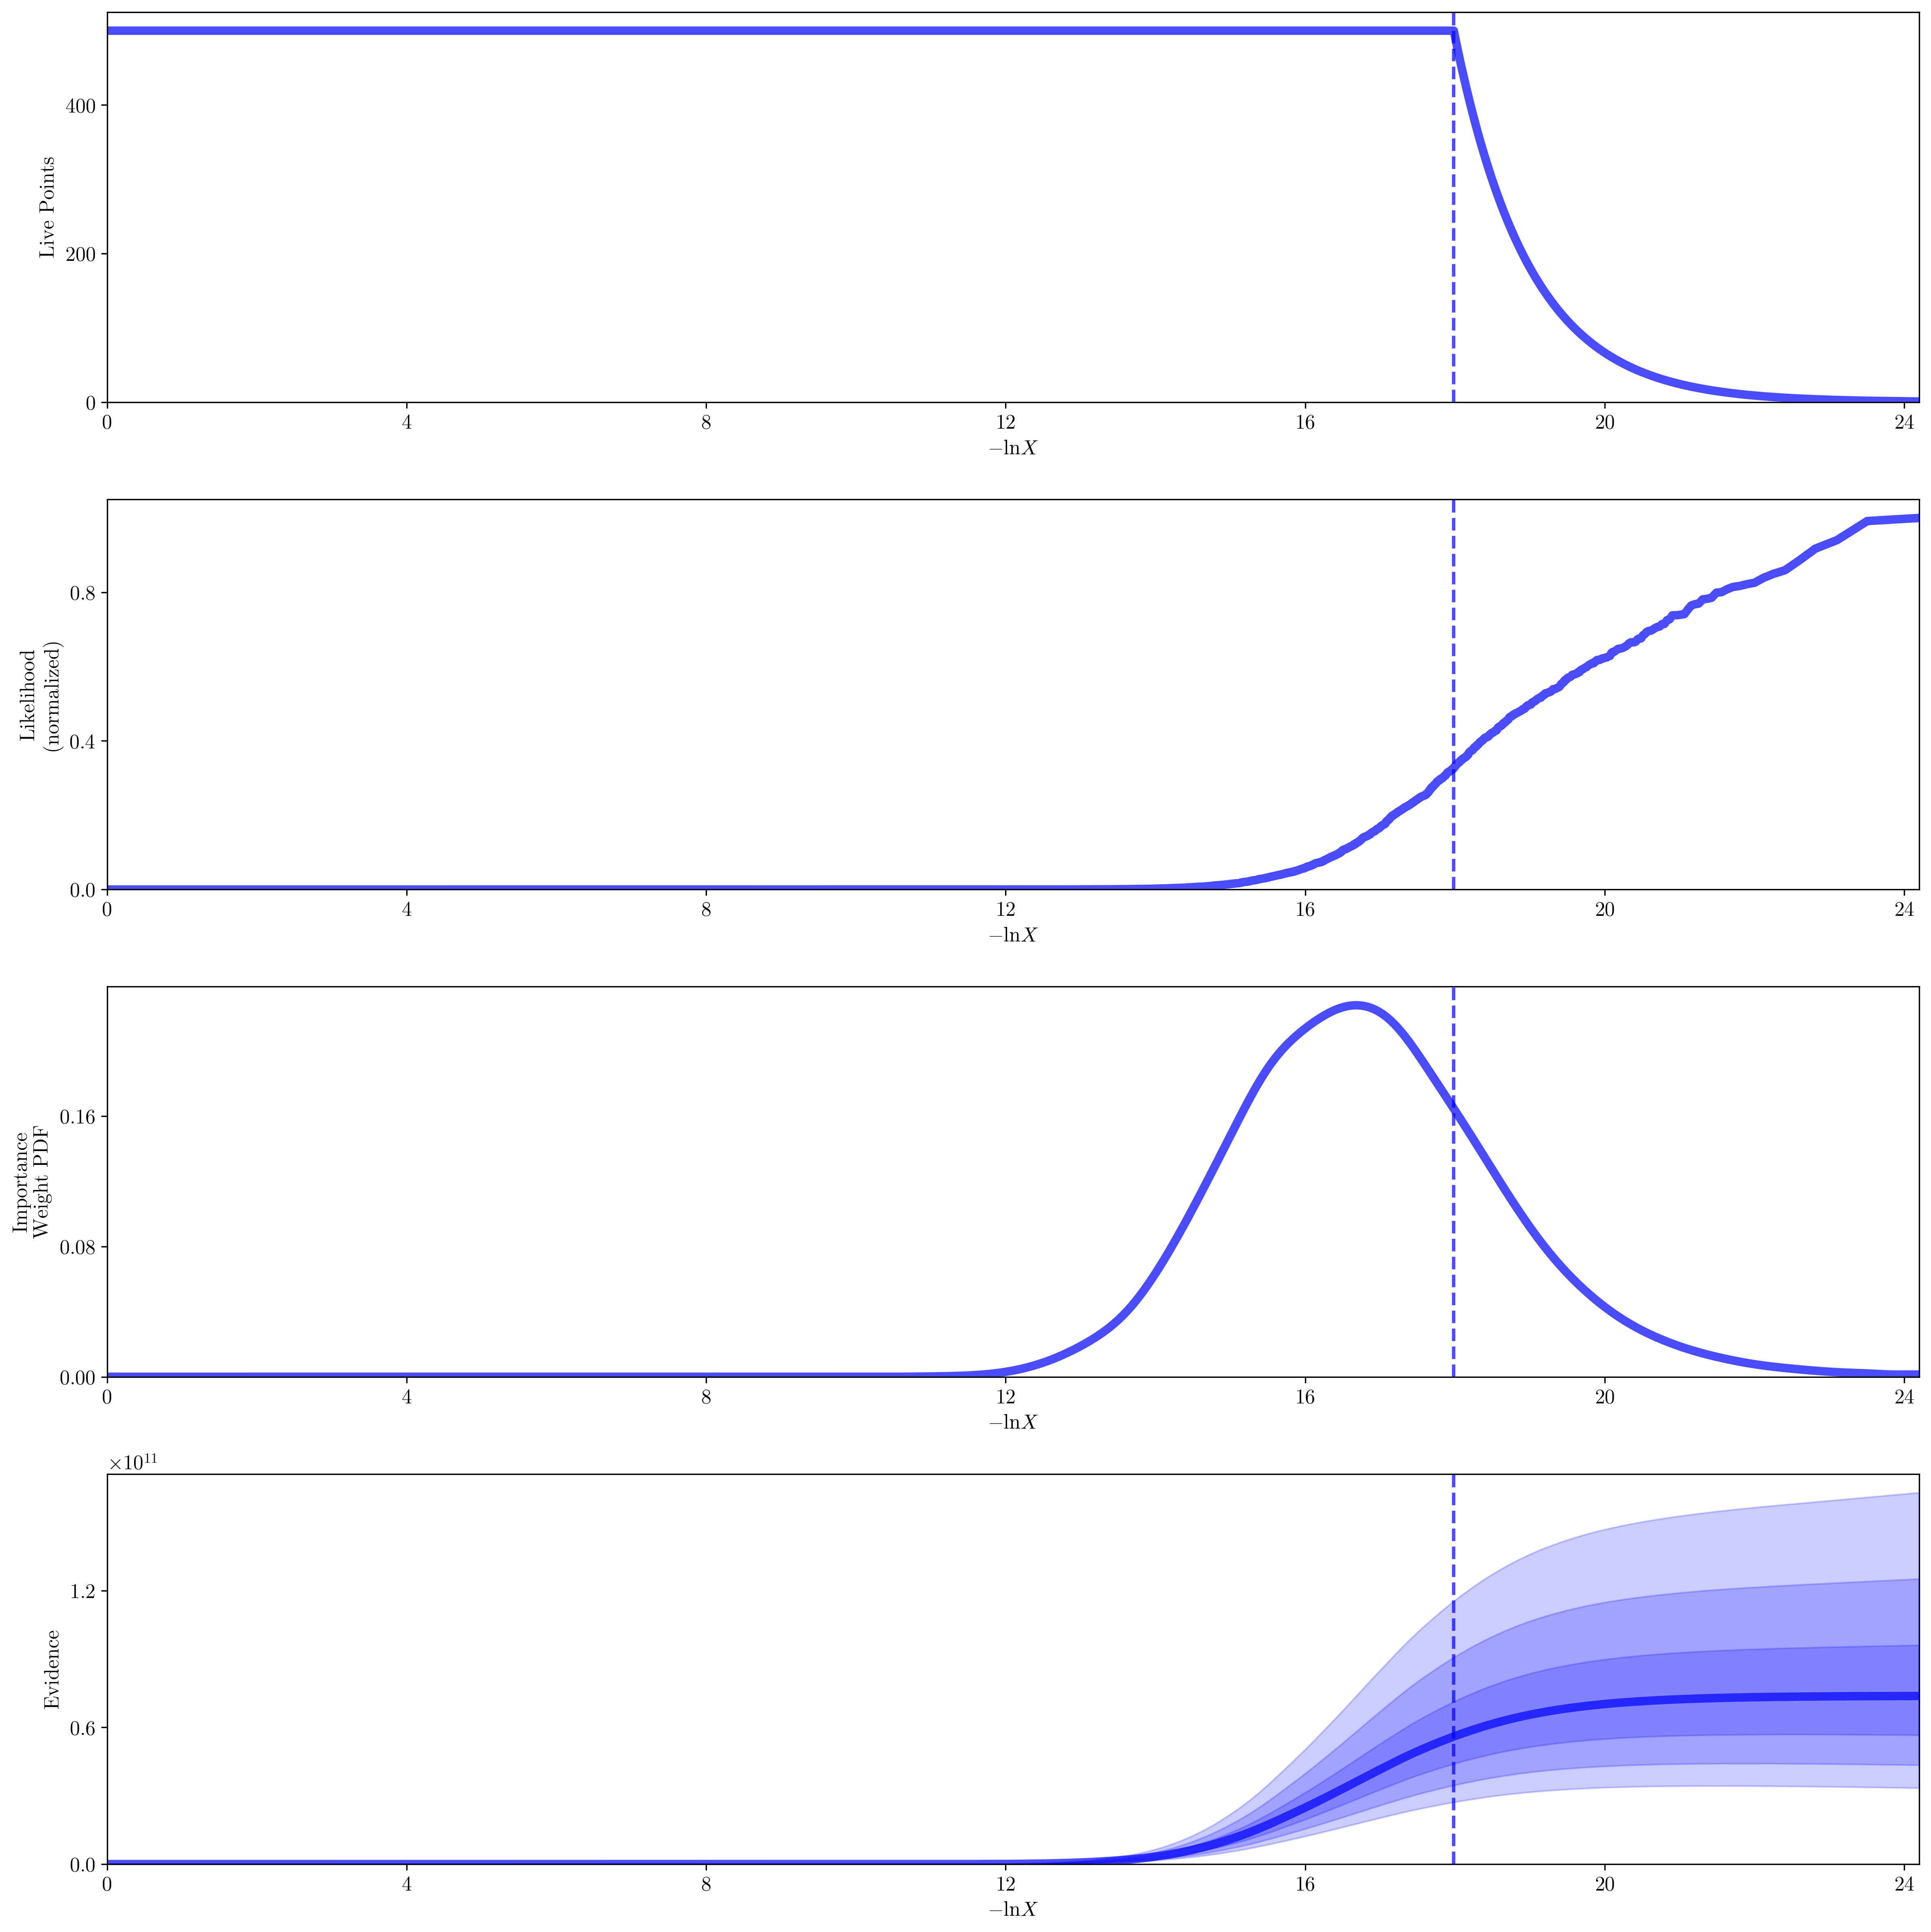

In [320]:
rfig, raxes = dyplot.runplot(results_4d)
rfig.tight_layout()

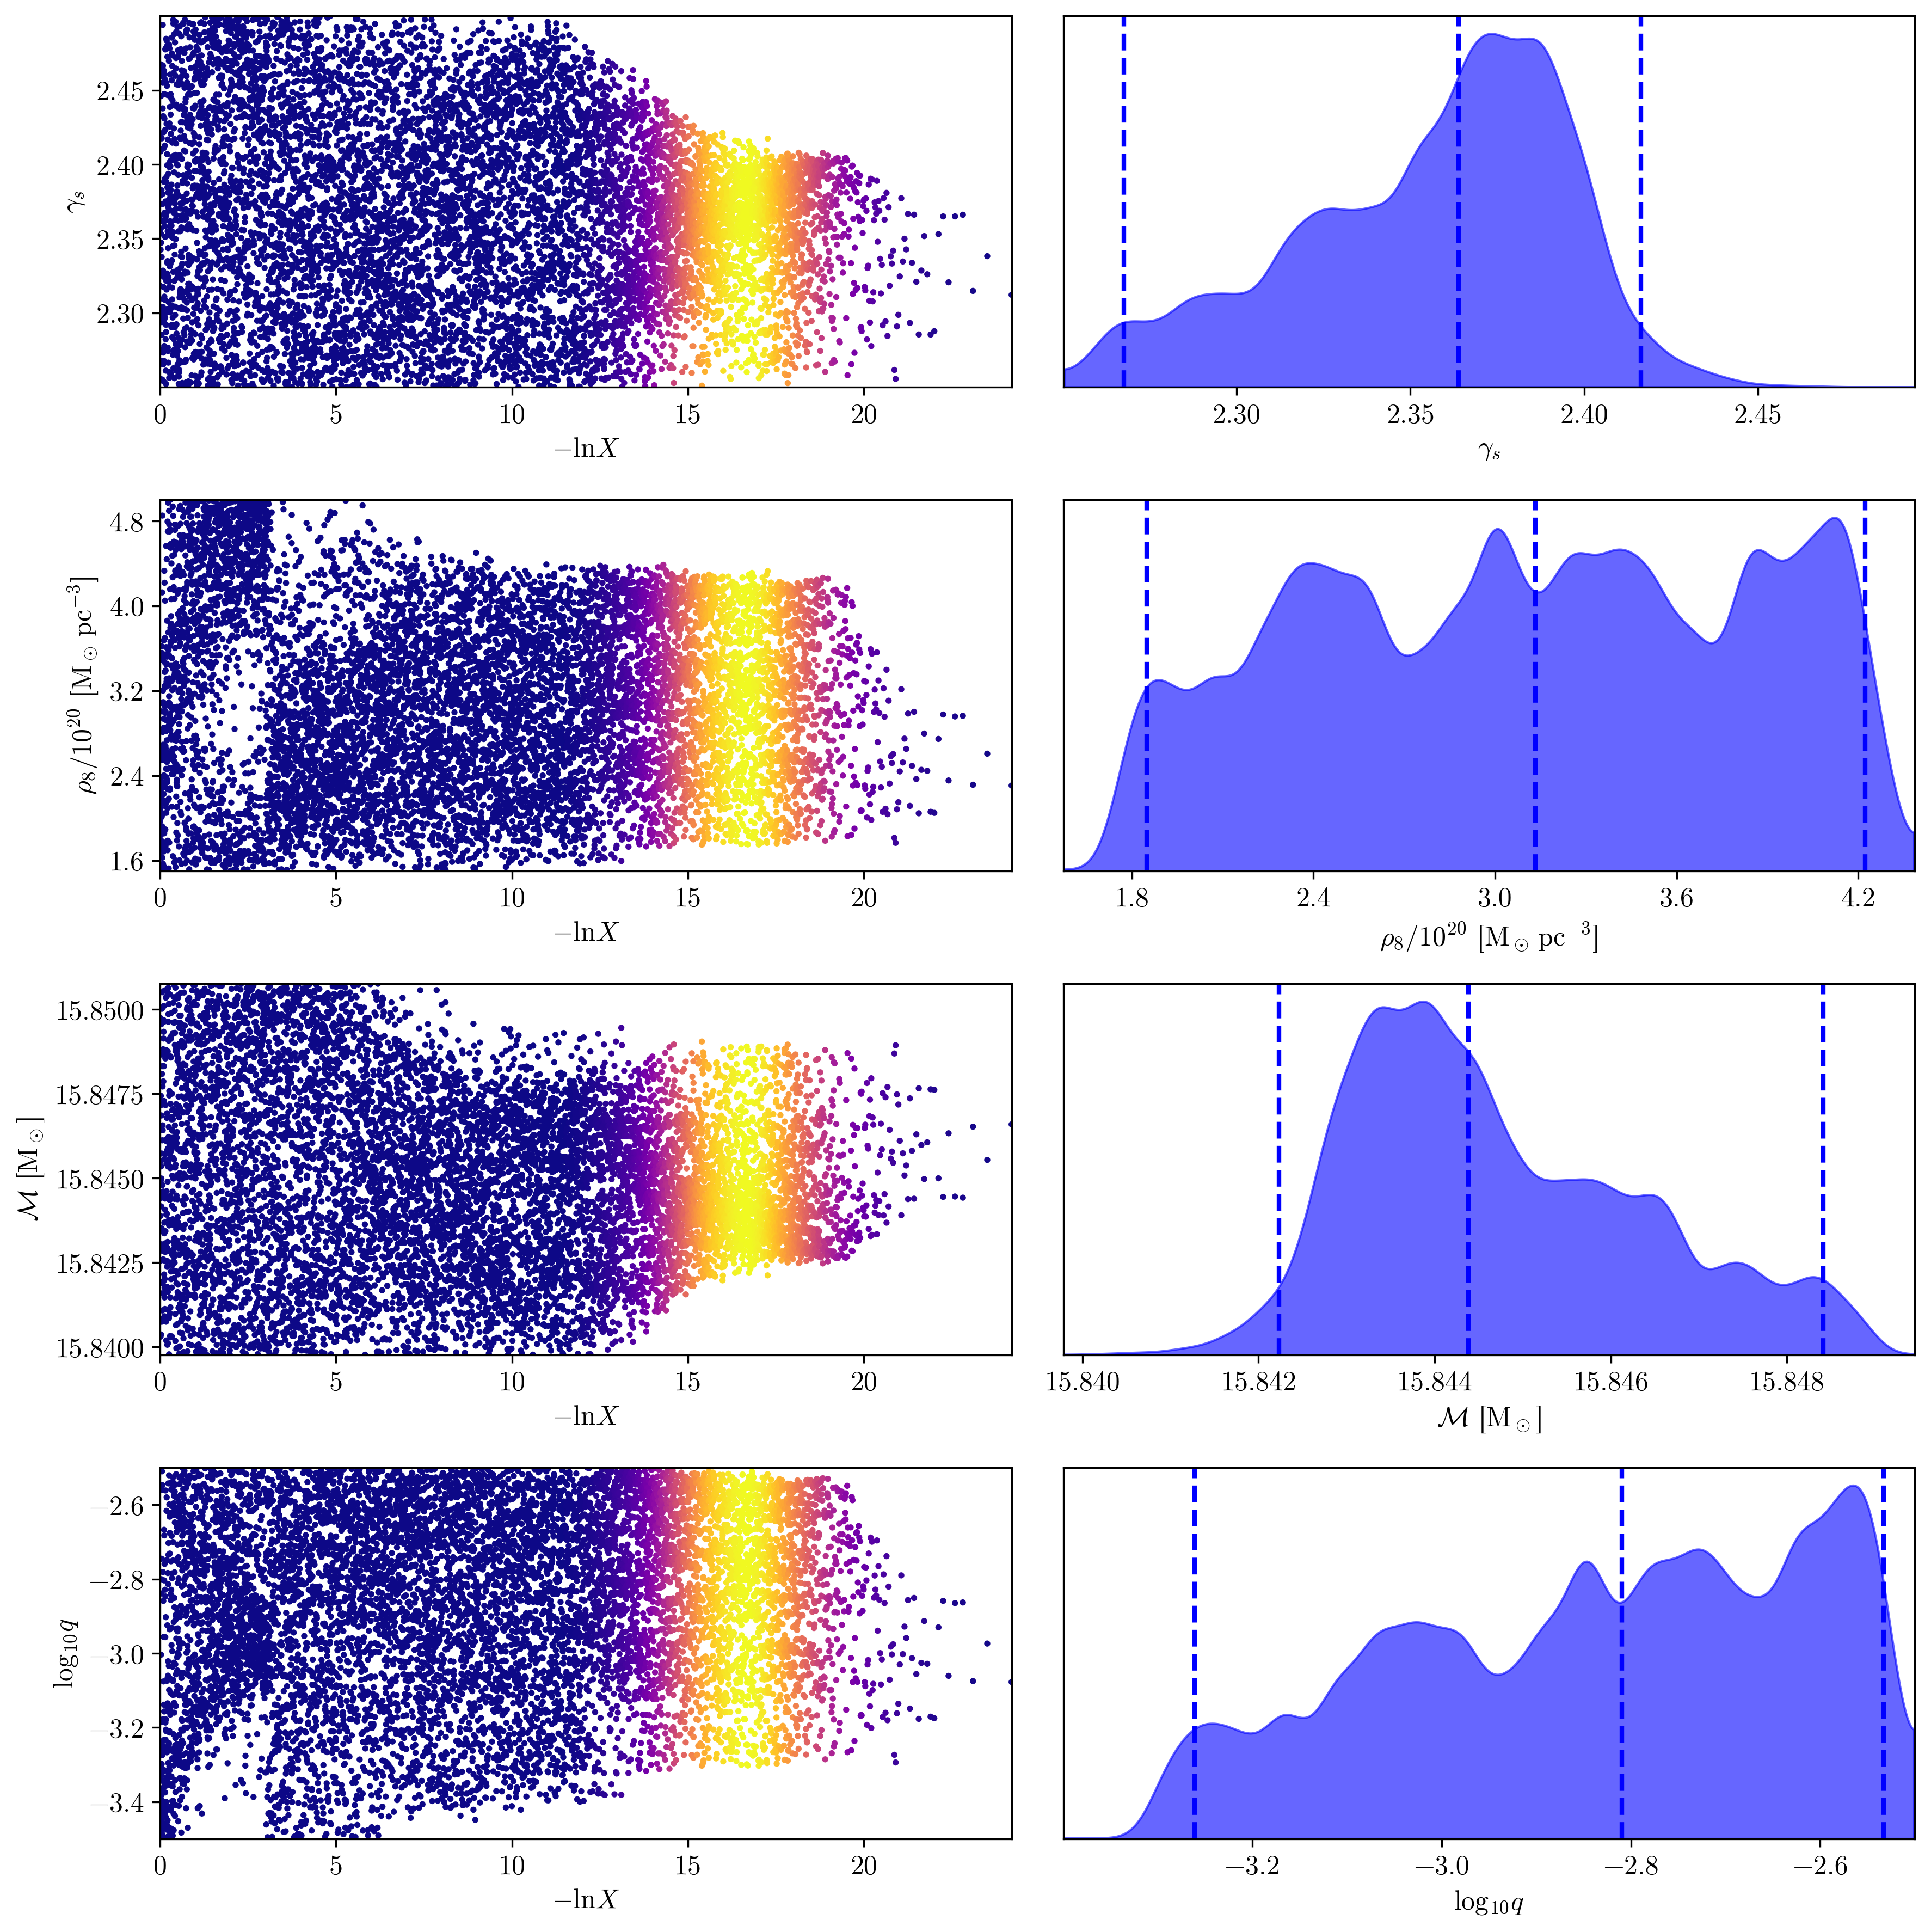

In [321]:
tfig, taxes = dyplot.traceplot(results_4d, labels=labels)
tfig.tight_layout()

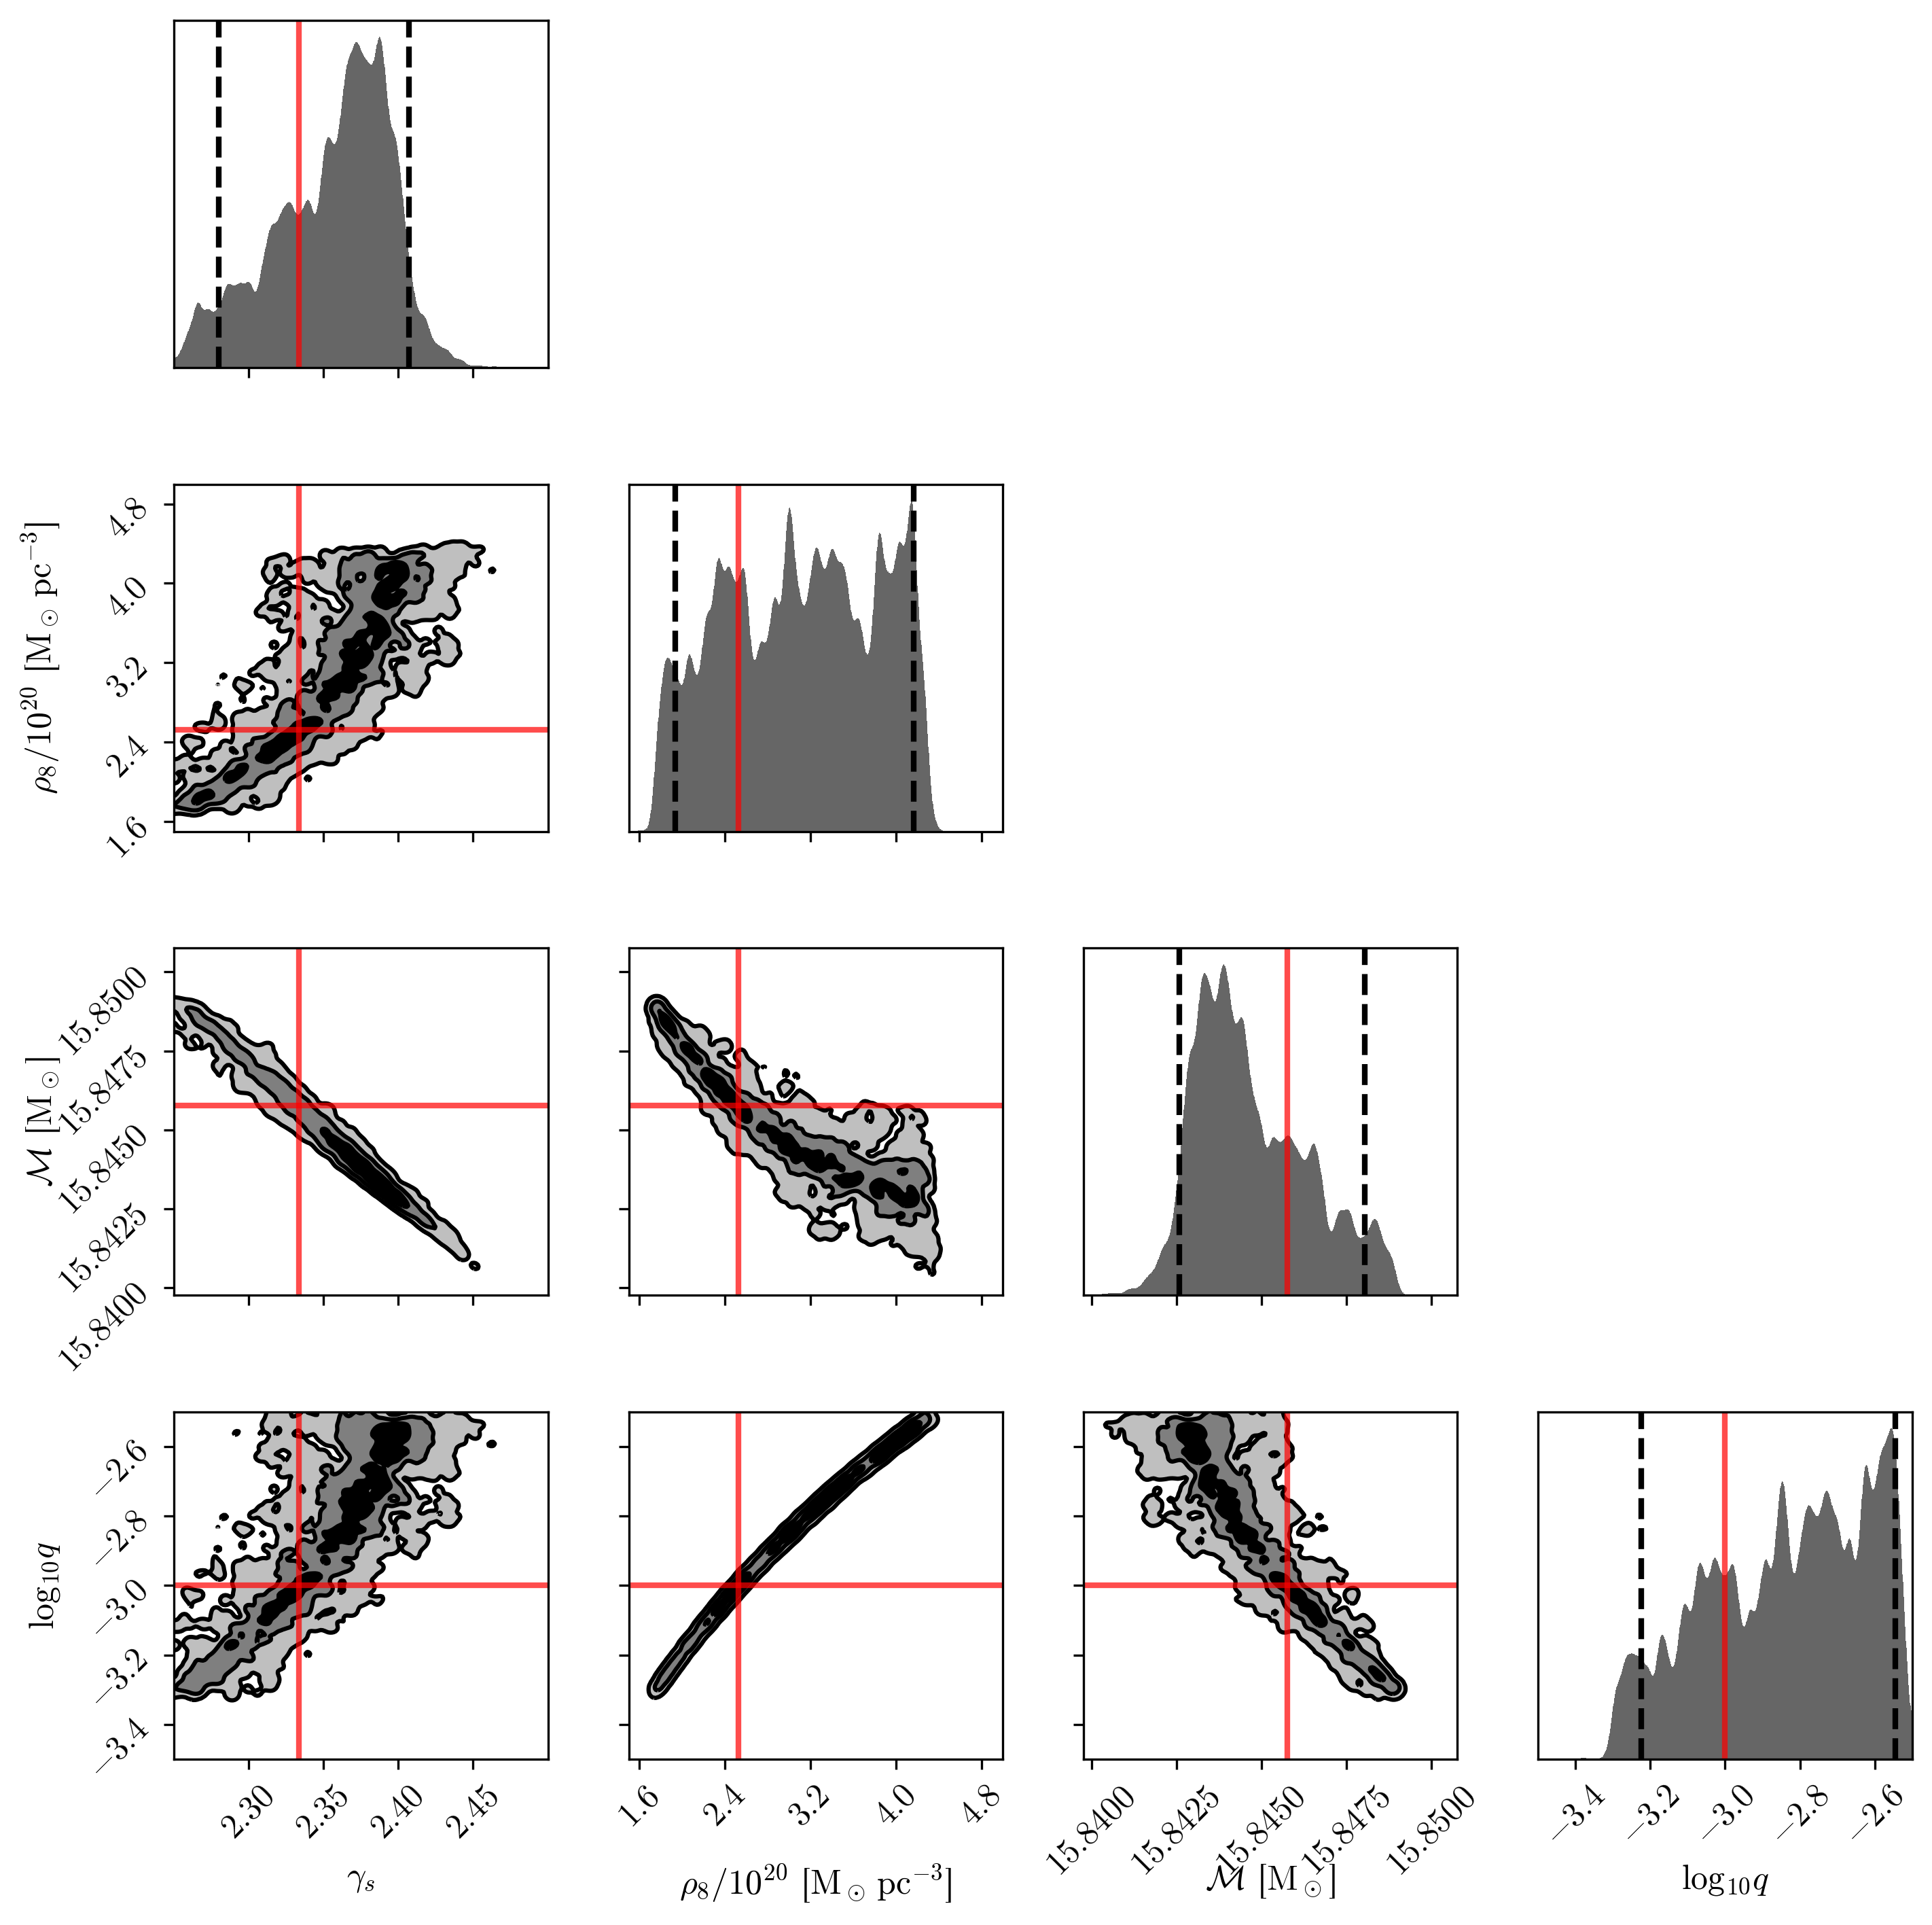

In [359]:
cfig, caxes = dyplot.cornerplot(
    results_4d,
    labels=labels,
    quantiles=[1 - 0.95, 0.95],
    quantiles_2d=[1 - np.exp(-(x ** 2) / 2) for x in [1, 2, 3]],
    smooth=0.01,
    truths=(
        gamma_s,
        rho_8T,
        dd_s.M_chirp / MSUN,
        jnp.log10(dd_s.q),
    ),
    span=[1, 1, 1, 1]
)
cfig.tight_layout()
cfig.savefig("4d-dynesty-sampler_4d-measurable-eda.pdf")
cfig.savefig("4d-dynesty-sampler_4d-measurable-eda.png")

GR-in-vacuum: $\mathcal{M}$ (chirp mass)

Dark dress: $\mathcal{M}$, $\rho_8$ (density profile normalization) $\gamma_s$ (density profile slope), $q$ (mass ratio)

$\rho(r) = \rho_8 \left( \frac{r}{10^{-8} \, \mathrm{pc}} \right)^{-\gamma_s}$

$\rho_s = \rho_s(m_1, \gamma_s)$

$\rho(r) = \rho_s \left( \frac{r}{r_s} \right)^{-\gamma_s}$

$\rho_8 = 0$

$-2 \log (L(D|d_D) / L(V|d_D)) \sim \chi^2$

$K = \frac{p(d_D|D)}{p(d_D|V)}$. $K \gtrsim 100 \implies$ "decisive evidence for $D$ vs $V$"

Nested sampling

Data $x$, parameters $\theta$

$p(x) = \int d\theta \, p(x,\theta) = \int d\theta \, p(x|\theta) p(\theta)$

dynesty

For Bradley

In [421]:
x, logL_4d_fft(x)

(DeviceArray([ 2.33333333,  2.52894792, 15.84576404, -3.        ], dtype=float64),
 Buffer(42.47274195, dtype=float64))

In [420]:
results_4d.samples[results_4d.logl.argmax()], results_4d.logl.max()

(array([ 2.3121959 ,  2.30674841, 15.84659363, -3.07728314]), 42.3195999397791)

In [350]:
idxs = jnp.where(results_4d.samples[:, 1] > 4)
logls = results_4d.logl[idxs][-500:]
pts = results_4d.samples[idxs][-500:]
jnp.savez("rho8T_gt_4.npz", pts=pts, logls=logls)

Text(0, 0.5, '$\\rho_8 / 10^{20}$ [$\\mathrm{M}_\\odot \\, \\mathrm{pc}^{-3}$]')

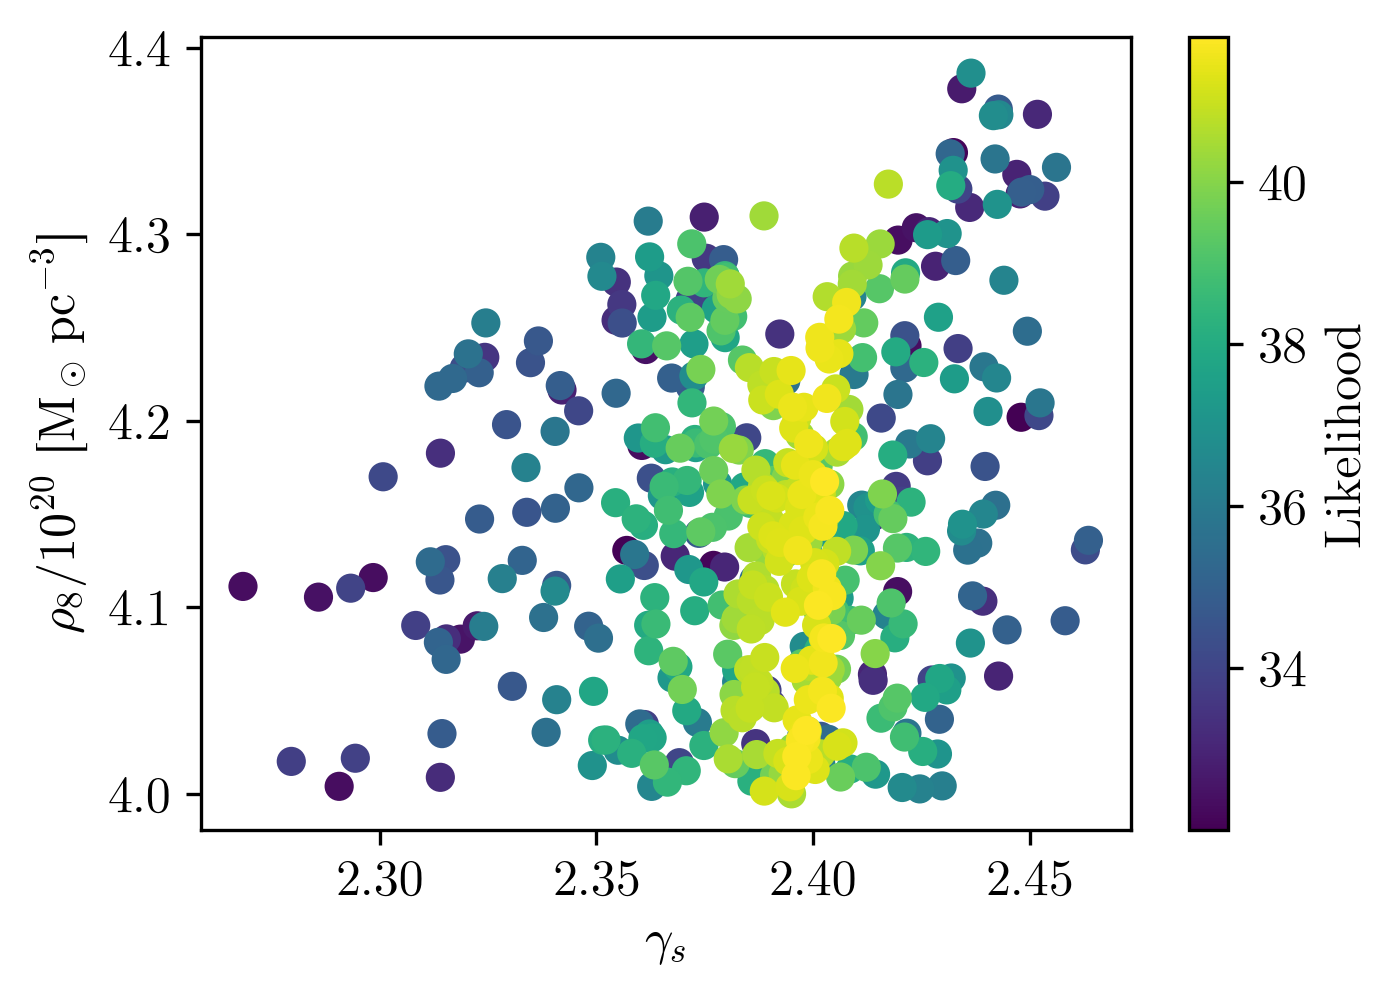

In [357]:
plt.scatter(pts[:, 0], pts[:, 1], c=logls)
plt.colorbar(label="Likelihood")
plt.xlabel(labels[0])
plt.ylabel(labels[1])

## Vacuum system with FFT likelihood

In [22]:
# @jax.jit
def logL_v(x):
    M_chirp = x[0] * MSUN
    vb_h = VacuumBinary(
        M_chirp,
        dd_s.Phi_c,  # fixed
        dd_s.tT_c,  # value doesn't matter
        dd_s.dL_iota,  # value doesn't matter
        dd_s.f_c,  # should give largest-possible likelihood
    )
    return loglikelihood_fft(vb_h, dd_s, f_l, dd_s.f_c, 100000, 3000)

In [23]:
dM_chirp_MSUN_range_v = jnp.array([1.6e-4, 1.85e-4])
labels_v = [r"$\mathcal{M}$ [M$_\odot$]"]


def ptform_v(u):
    dM_chirp_MSUN = (dM_chirp_MSUN_range_v[1] - dM_chirp_MSUN_range_v[0]) * u[
        0
    ] + dM_chirp_MSUN_range_v[0]
    return jnp.array([dd_s.M_chirp / MSUN + dM_chirp_MSUN])

Check the likelihood directly

In [24]:
M_chirp_MSUN_grid = jax.lax.map(ptform_v, jnp.linspace(0, 1, 40).reshape([-1, 1]))
logLs = jax.lax.map(logL_v, M_chirp_MSUN_grid)

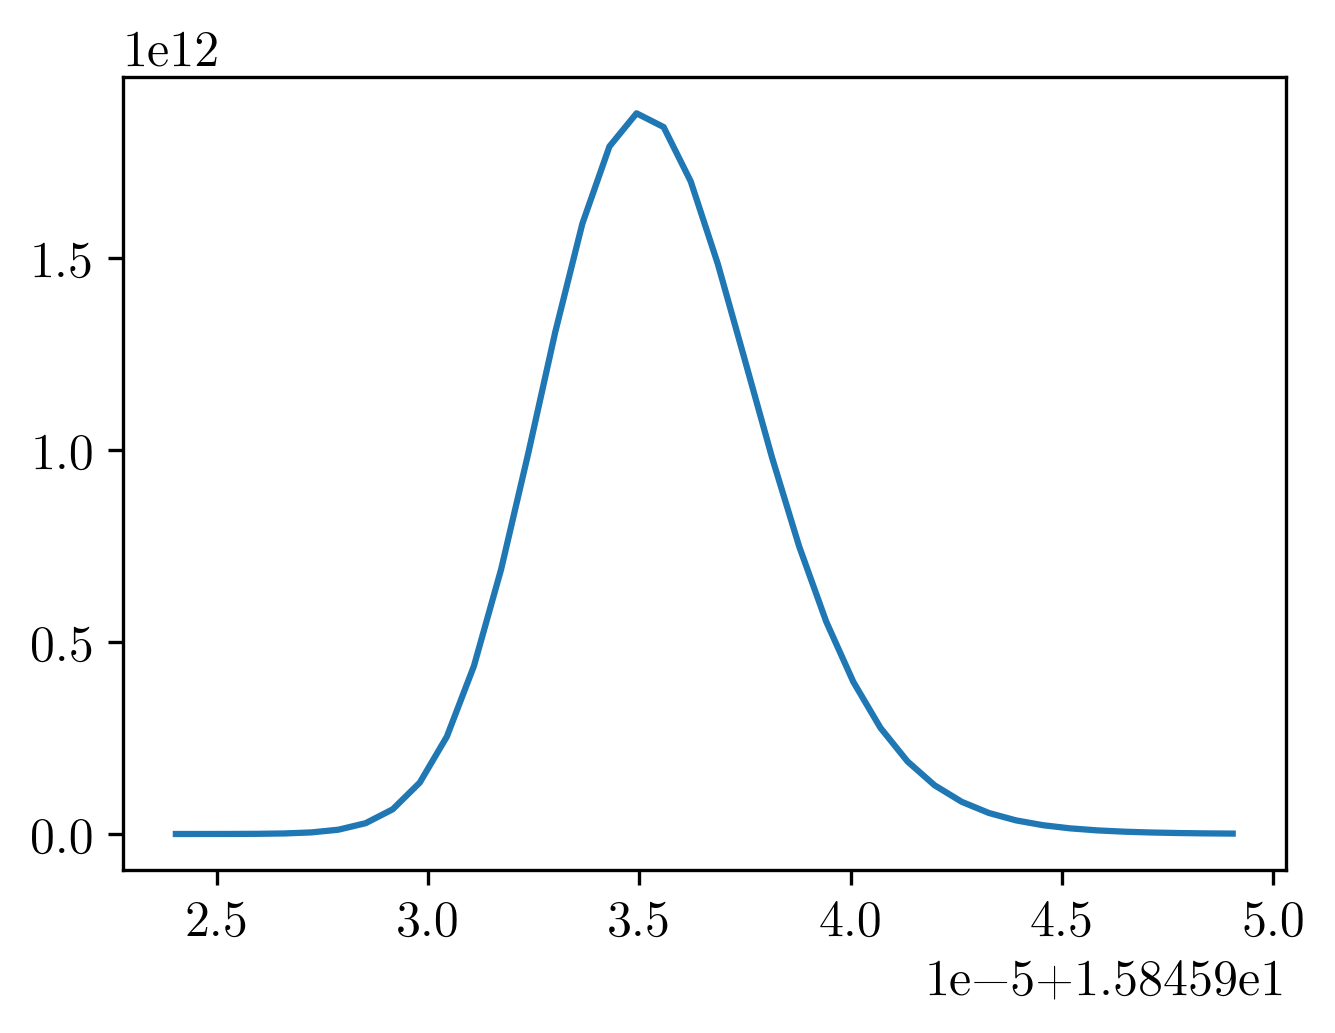

In [25]:
plt.plot(M_chirp_MSUN_grid, jnp.exp(logLs))

In [26]:
# Estimate maximum-likelihood vacuum system
idx_max = jnp.argmax(logLs)
dd_v_MLE = VacuumBinary(
    M_chirp_MSUN_grid[idx_max] * MSUN,
    dd_s.Phi_c,
    dd_s.tT_c,
    dd_s.dL_iota,
    dd_s.f_c,
)
print("MLE V params = ", dd_v_MLE.M_chirp[0] / MSUN)
print("True params  = ", dd_s.M_chirp / MSUN, "\n")

dN_naive = (Phi_to_c(f_l, dd_v) - Phi_to_c(f_l, dd_s)) / (2 * pi)
dN = (Phi_to_c(f_l, dd_v_MLE) - Phi_to_c(f_l, dd_s)) / (2 * pi)
print(f"dN (naive) = {dN_naive}")
print(f"dN (MLE)   = {dN[0]}\n")

print(f"logL(D|D)     = {loglikelihood_fft(dd_s, dd_s, f_l, dd_s.f_c, 3000, 3000)}")
print(f"logL(V_MLE|D) = {loglikelihood_fft(dd_v_MLE, dd_s, f_l, dd_s.f_c, 3000, 3000)}")

MLE V params =  15.845934936140285
True params  =  15.845764038704388 

dN (naive) = 92.3472252904477
dN (MLE)   = -10.373111393966727

logL(D|D)     = 49.808935411757446
logL(V_MLE|D) = 32.14328335223476


Run nested sampling

In [27]:
sampler_v = dynesty.NestedSampler(logL_v, ptform_v, 2, nlive=100, bound="multi")
sampler_v.run_nested()
results_v = sampler_v.results

815it [02:22,  5.73it/s, +300 | bound: 0 | nc: 1 | ncall: 4369 | eff(%): 25.521 | loglstar:   -inf < 28.262 <    inf | logz: 26.871 +/-  0.043 | dlogz:  0.001 >  0.309]


In [28]:
results_v.summary()

Summary
nlive: 300
niter: 815
ncall: 4369
eff(%): 25.521
logz: 26.871 +/-  0.043


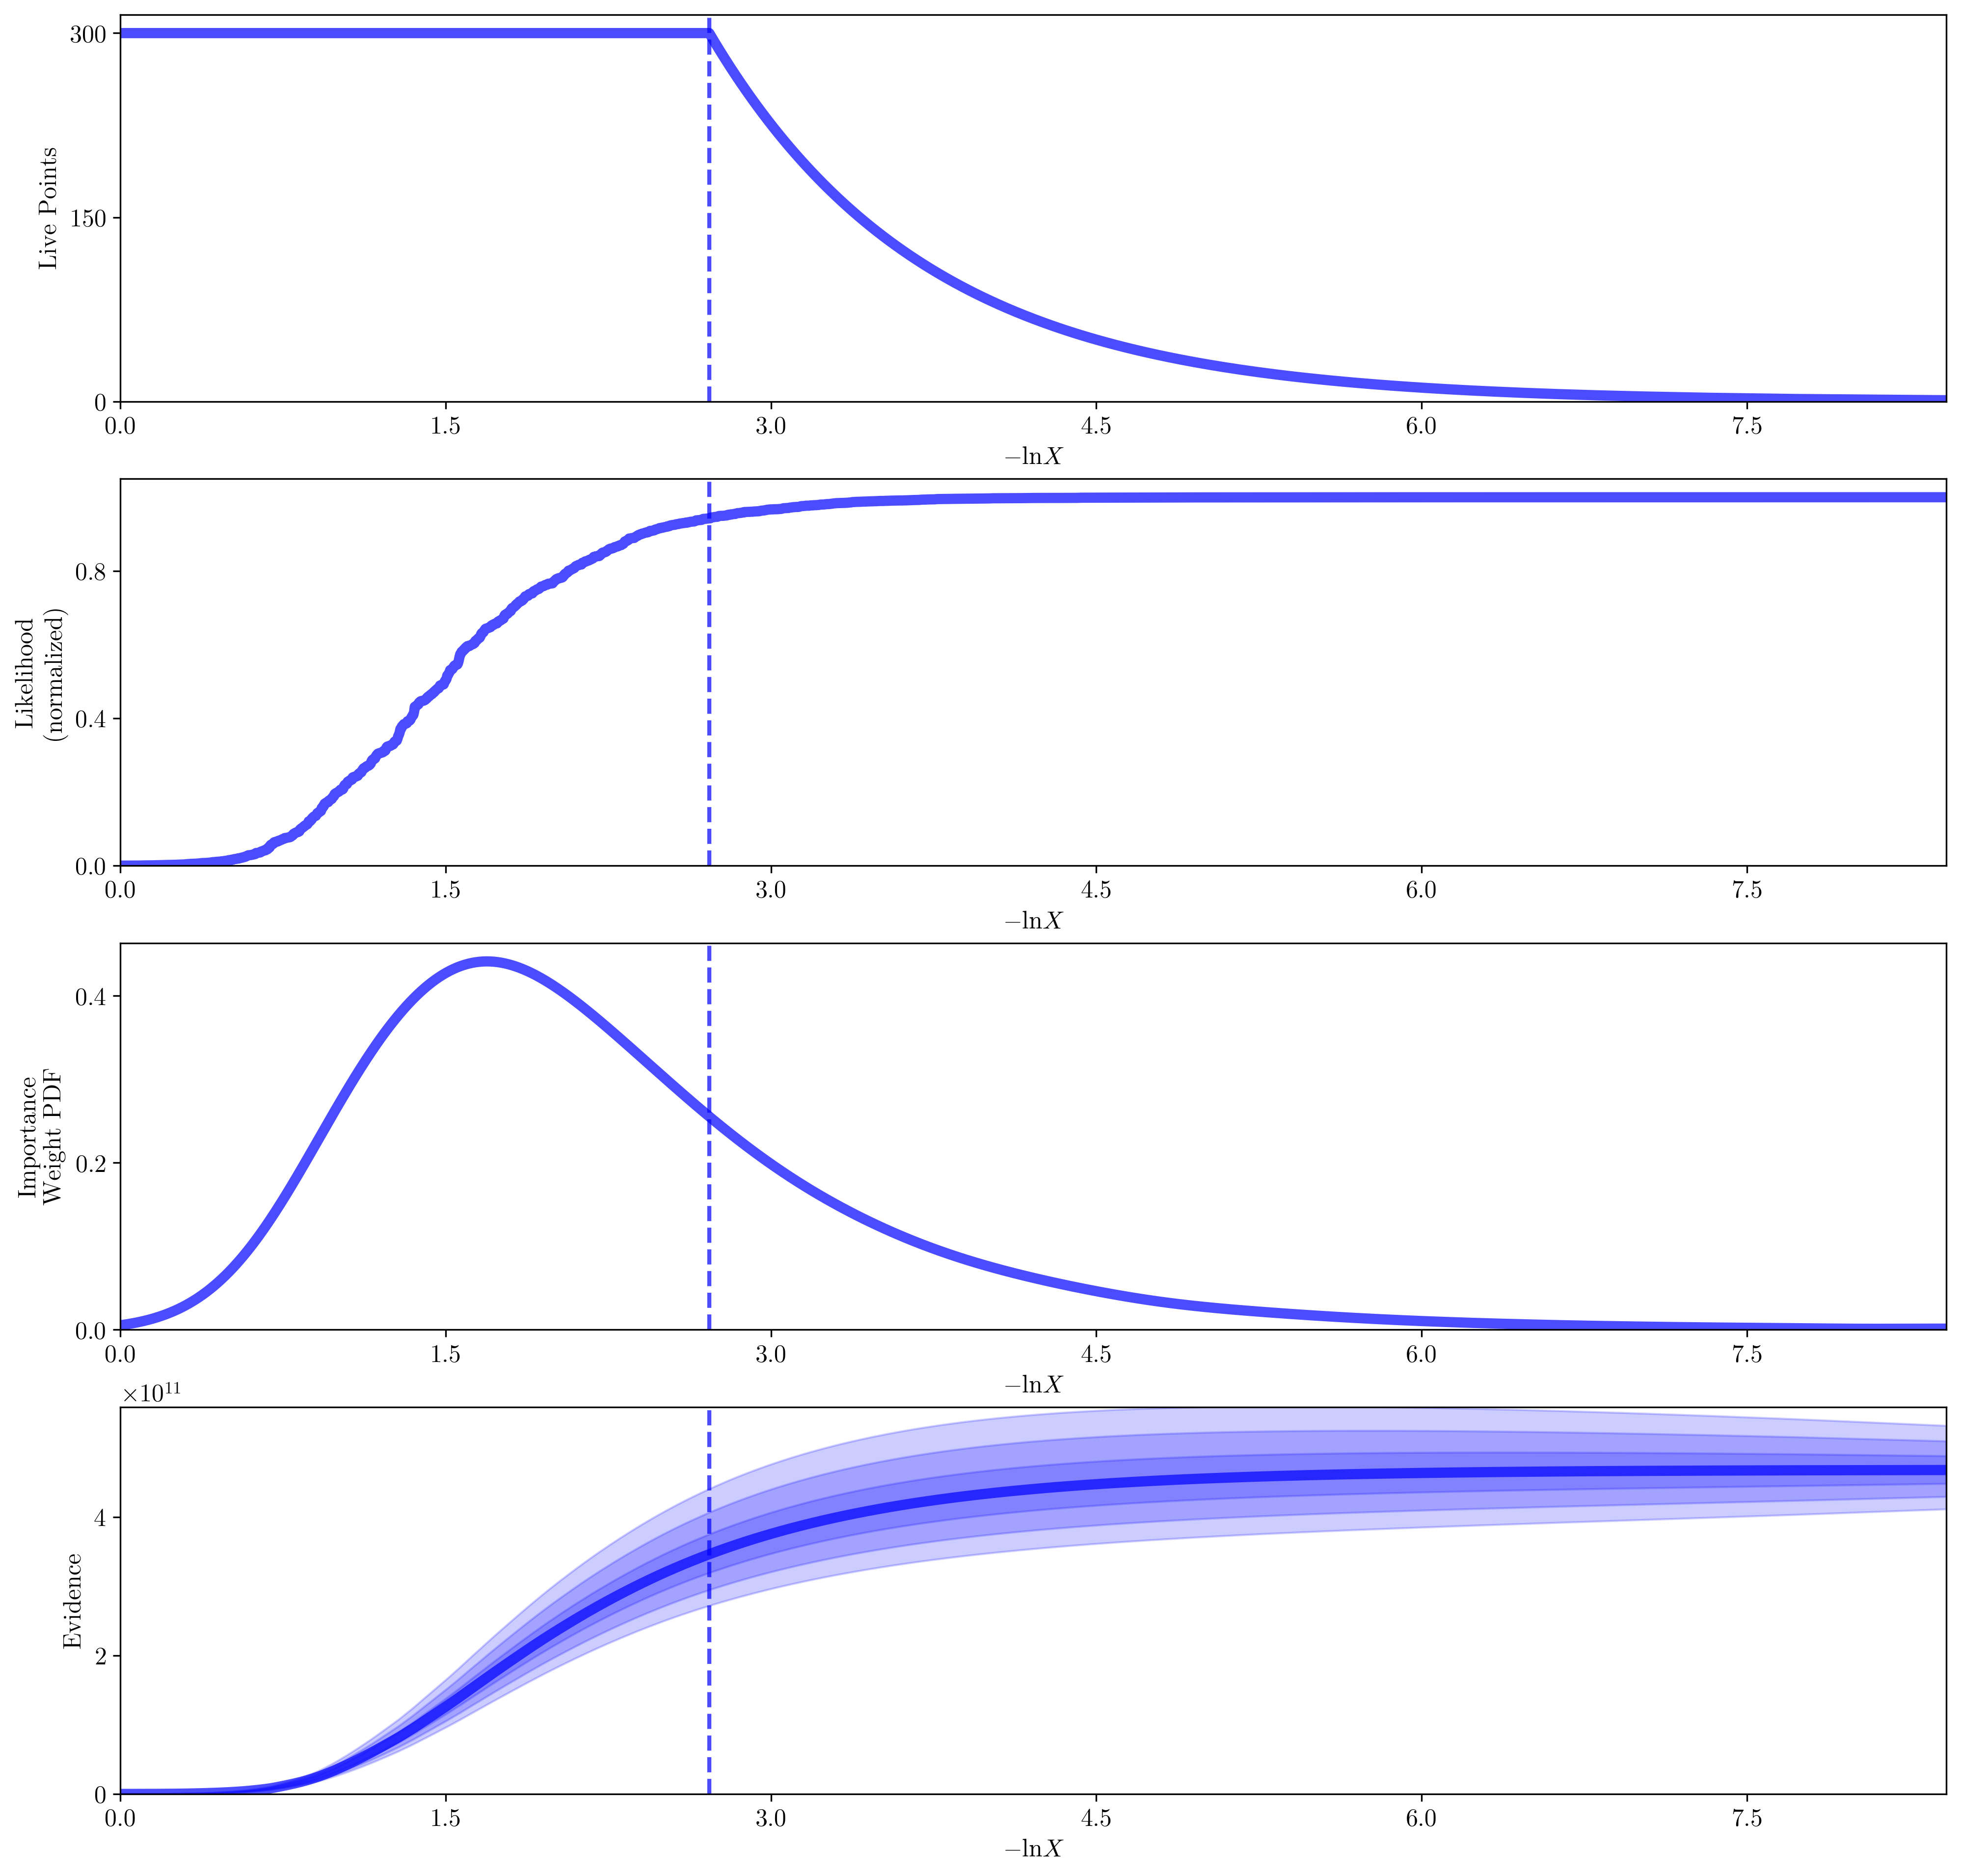

In [29]:
rfig, raxes = dyplot.runplot(results_v)

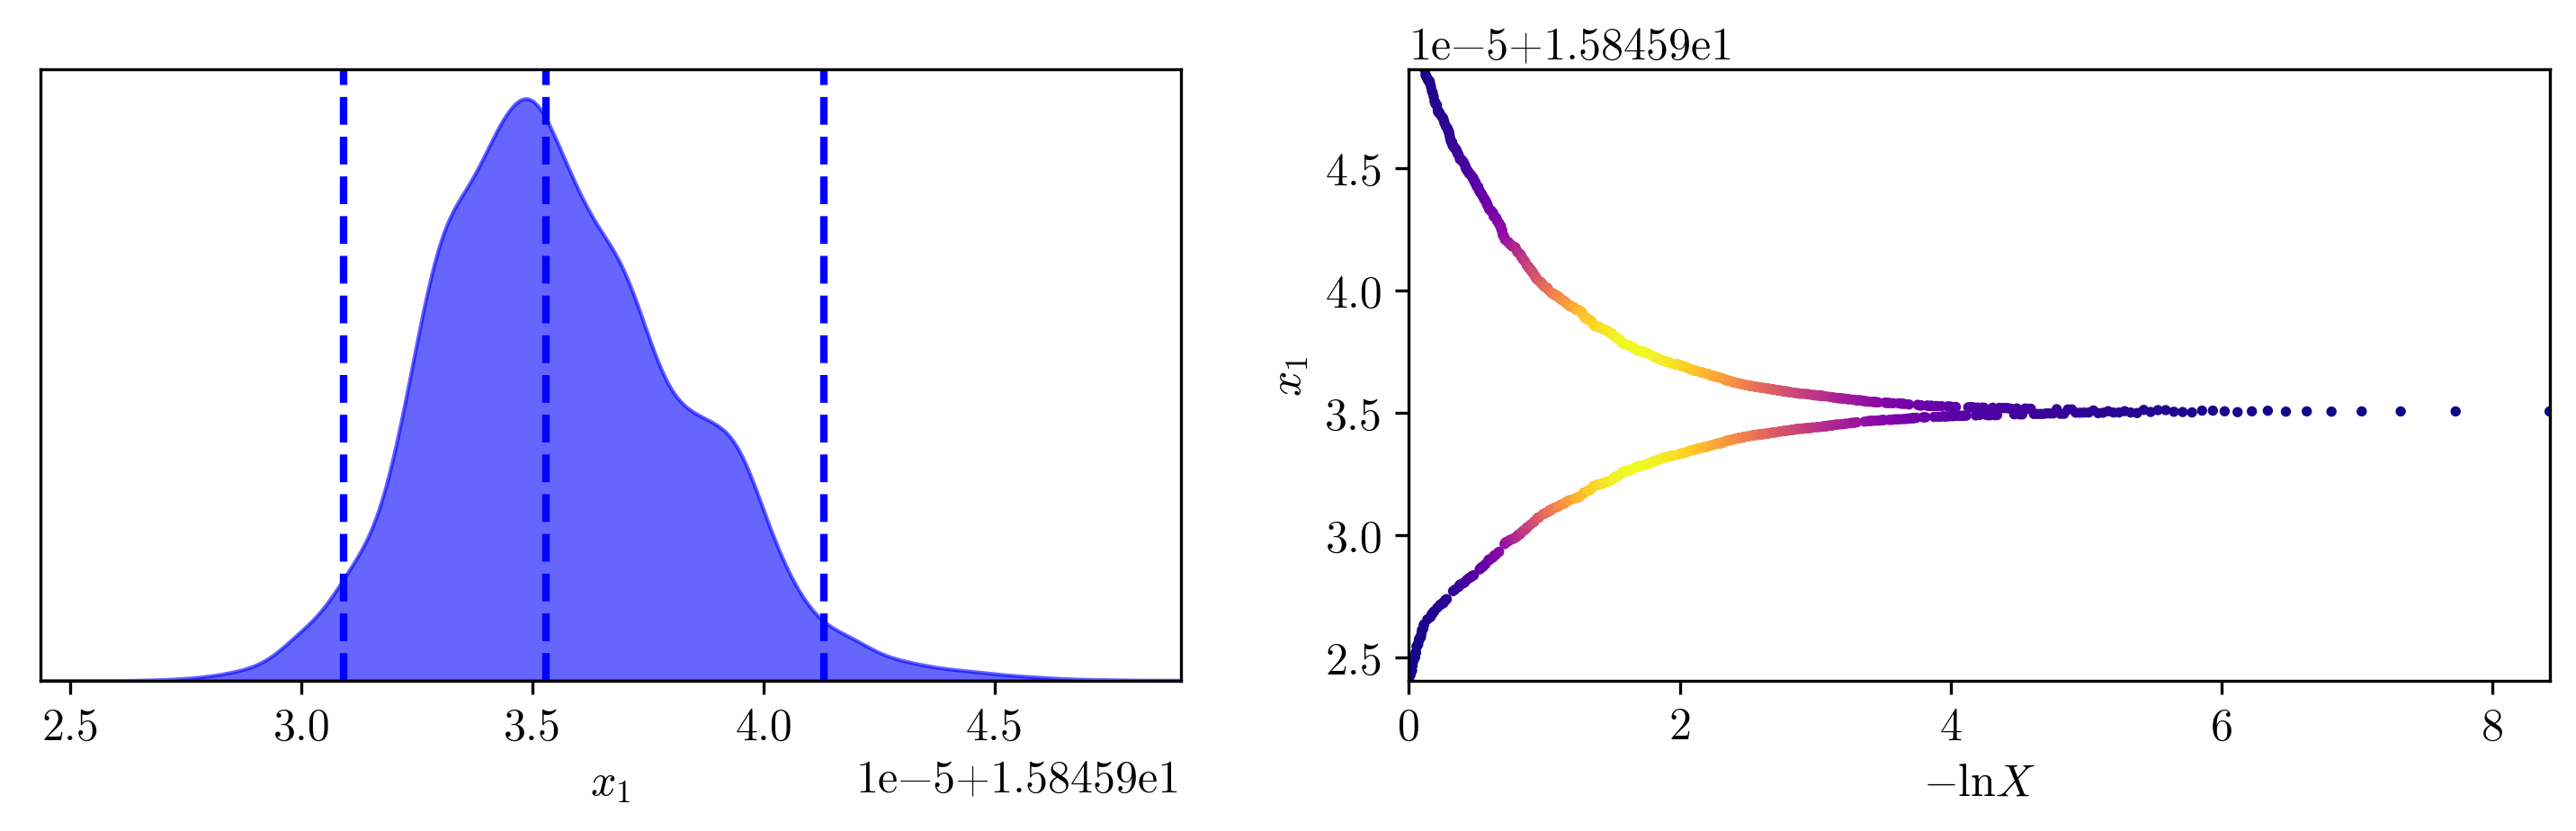

In [30]:
tfig, taxes = dyplot.traceplot(results_v)

p_v(x) = int dM p(x|M) p_v(M) = 1 / dM_v * int dM p(x|M)

p_d(x) = int dM dt p(x|M, t) p_d(M) p(t) = 1 / dM_d * int dM dt p(x|M, t) p(t)

K_NS = p_d(x) / p_v(x)

K = dM_d * p_d(x) / (dM_v * p_v(x))

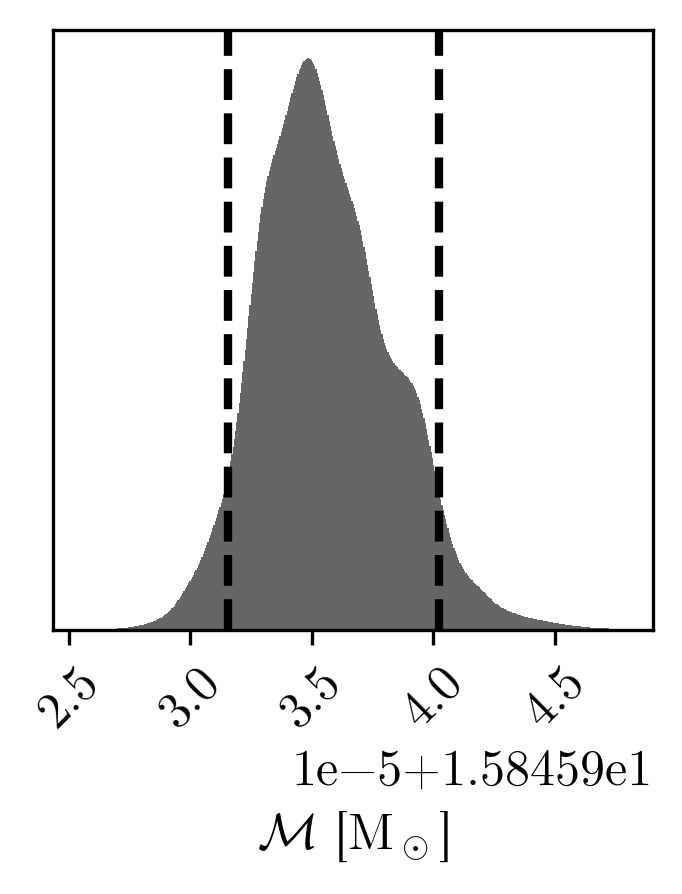

In [31]:
cfig, caxes = dyplot.cornerplot(
    results_v,
    labels=labels_v,
    quantiles=[1 - 0.95, 0.95],
    quantiles_2d=[1 - np.exp(-(x ** 2) / 2) for x in [1, 2, 3]],
)

Bias in $\sigma$s

In [63]:
((15.8459 + 3.5e-5) - (dd_s.M_chirp / MSUN)) / 0.5e-5

DeviceArray(34.19225912, dtype=float64)

Evidence comparison!

In [32]:
bayes_fact_ns = jnp.exp(results.logz[-1]) / jnp.exp(results_v.logz[-1])
bayes_fact_est = (
    (dM_chirp_MSUN_range[1] - dM_chirp_MSUN_range[0])
    / (dM_chirp_MSUN_range_v[1] - dM_chirp_MSUN_range_v[0])
    * bayes_fact_ns
)
print(f"K >= {bayes_fact_est}")

K >= 2856.437058076377
